### 📌 Introdução

Este projeto tem como objetivo desenvolver um modelo preditivo de risco de crédito utilizando dados históricos do Home Credit, armazenados no formato `.parquet`. O processo foi desenvolvido em Python, com o uso das bibliotecas **Polars**, **Pandas**, **LightGBM** e **scikit-learn**.

Os principais passos do pipeline foram:

- 📂 **Leitura de múltiplos arquivos .parquet**, incluindo:
  - `train_base.parquet` (base principal),
  - `train_deposit_1.parquet` (depósitos bancários),
  - `train_person_1.parquet` (dados demográficos),
  - `train_credit_bureau_b_1.parquet` (histórico de crédito).

- 🧹 **Tratamento e conversão de colunas**, especialmente datas.

- 🧠 **Engenharia de variáveis**, com agregações por `case_id` (média, soma, contagem, duração etc.).

- 🤖 **Treinamento de modelo LightGBM**, com validação estratificada.

- 📊 **Avaliação de desempenho**, por métricas (AUC, Gini), curva ROC, importância de variáveis e estabilidade ao longo do tempo.

O foco do modelo é prever a inadimplência com base em variáveis financeiras, comportamentais e demográficas, com análises que suportem decisões de crédito.

In [1]:
# imports principais
import polars as pl
import pandas as pd
import numpy as np
import lightgbm as lgb
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score , roc_curve
import matplotlib.pyplot as plt

### Funções Genéricas
- Essas funções formam o “kit básico” de *ingestão* e *EDA* do projeto. Elas deixam o notebook mais limpo, evitam código repetido e permitem ajustes centralizados caso caminhos ou formatos mudem.


In [2]:
DATA_DIR_PARQUET = Path("data/parquet_files/train")
def read_parquet_dir(name: str) -> pl.DataFrame:
    return pl.read_parquet(DATA_DIR_PARQUET / name)

def ver_dataframe(dataframe: pd):
    # Ver o número de linhas e colunas
    print("Tamanho da tabela:", dataframe.shape)

    # Ver os nomes das primeiras 20 colunas e seus tipos
    for nome, tipo in zip(dataframe.columns[:20], dataframe.dtypes[:20]):
        print(f"{nome:40} → {tipo}")
    
    # Conta quantos valores vazios existem em cada coluna
    faltantes = dataframe.null_count()
    print(f"\nValores Nulos por Coluna\n{faltantes}")
    
    print(dataframe.head(5))

def ver_coluna_df(dataframe: pd, coluna, lines=5):
    # Conferir rapidamente
    print(dataframe["date_decision"].head(lines))
    print("Tipo da coluna agora:", dataframe["date_decision"].dtype)
    
# Converter datas de texto/inteiro para Date
def converter_texto_data(dataframe: pd, date_cols: list):
    new_dataframe = dataframe
    for col in date_cols:
        new_dataframe = new_dataframe.with_columns(
            pl.col(col)
            .str.strptime(pl.Date, "%Y-%m-%d", strict=False)  # ajuste formato se precisar
            .alias(col)
        )
    return new_dataframe
    
def ver_dist_column(dataframe: pd, columns):
    dist_target = dataframe.select(pl.col(columns).value_counts())
    print(dist_target)
    

### Importação do DataFrame Meste

Carrega o arquivo principal `train_base.parquet`, converte a coluna `date_decision` para data e, se `verbose=True`, exibe:

- Tamanho da base e tipos das colunas (`ver_dataframe`)
- Verificação da coluna `date_decision` (`ver_coluna_df`)
- Distribuição da variável `target` (`ver_dist_column`)

Retorna um `pl.DataFrame` pronto para engenharia de features.


In [3]:
def load_master_dataframe(verbose: bool = True) -> pl.DataFrame:
    """
    Carrega o arquivo principal (train_base.parquet),
    converte a coluna date_decision para tipo Date
    e faz uma inspeção básica opcional.

    Parâmetros
    ----------
    verbose : bool (default=True)
        Se True, imprime:
        • shape, tipos e nulos            (ver_dataframe)
        • amostra e dtype de date_decision (ver_coluna_df)
        • distribuição do target           (ver_dist_column)

    Retorno
    -------
    pl.DataFrame
        DataFrame já limpo e pronto para receber features.
    """
    # 1. Lê o arquivo Parquet base
    df = read_parquet_dir("train_base.parquet")

    # 2. Converte a coluna de data
    df = converter_texto_data(df, ["date_decision"])

    # 3. EDA rápida (opcional)
    if verbose:
        ver_dataframe(df)
        ver_coluna_df(df, "date_decision")
        ver_dist_column(df, "target")

    return df


In [4]:
df = load_master_dataframe()

Tamanho da tabela: (1526659, 5)
case_id                                  → Int64
date_decision                            → Date
MONTH                                    → Int64
WEEK_NUM                                 → Int64
target                                   → Int64

Valores Nulos por Coluna
shape: (1, 5)
┌─────────┬───────────────┬───────┬──────────┬────────┐
│ case_id ┆ date_decision ┆ MONTH ┆ WEEK_NUM ┆ target │
│ ---     ┆ ---           ┆ ---   ┆ ---      ┆ ---    │
│ u32     ┆ u32           ┆ u32   ┆ u32      ┆ u32    │
╞═════════╪═══════════════╪═══════╪══════════╪════════╡
│ 0       ┆ 0             ┆ 0     ┆ 0        ┆ 0      │
└─────────┴───────────────┴───────┴──────────┴────────┘
shape: (5, 5)
┌─────────┬───────────────┬────────┬──────────┬────────┐
│ case_id ┆ date_decision ┆ MONTH  ┆ WEEK_NUM ┆ target │
│ ---     ┆ ---           ┆ ---    ┆ ---      ┆ ---    │
│ i64     ┆ date          ┆ i64    ┆ i64      ┆ i64    │
╞═════════╪═══════════════╪════════╪══════════╪═══

### Depósito features

Enriquece o DataFrame mestre com estatísticas dos depósitos (`train_deposit_1.parquet`):

1. **Leitura & limpeza**  
   - Converte `openingdate_313D` e `contractenddate_991D` para datas.  
   - Cria flag `dep_active_flag` (1 = contrato ainda ativo).

2. **Feature nova**  
   - `dep_contract_duration` → dias entre abertura e encerramento (ou hoje, se ativo).

3. **Agregação por `case_id`**  
   | Feature criada | Significado |
   |----------------|-------------|
   | `dep_amt_mean` | valor médio dos depósitos |
   | `dep_amt_max`  | maior depósito registrado |
   | `dep_ops_cnt`  | quantidade de operações |
   | `dep_has_active` | 1 se há contrato de depósito ativo |
   | `dep_dur_mean` | duração média (dias) dos contratos |

4. **Join** dessas features à base principal.

Retorna `df` com 5 novas colunas de depósito.


In [5]:
def add_deposit_features(df: pl.DataFrame) -> pl.DataFrame:
    # 1. Carrega os dados de depósito
    dep = read_parquet_dir("train_deposit_1.parquet")
    
    # 2. Converte colunas de data
    dep = converter_texto_data(dep, ["openingdate_313D", "contractenddate_991D"])
    
    # 3. Tratar nulos: flag + preenchimento provisório
    dep = dep.with_columns([
        pl.col("contractenddate_991D").is_null().cast(pl.Int8).alias("dep_active_flag"),
        pl.when(pl.col("contractenddate_991D").is_null())
          .then(pl.col("openingdate_313D"))
          .otherwise(pl.col("contractenddate_991D"))
          .alias("contractenddate_991D")
    ])
    
    # 4. Cria coluna de duração do contrato
    dep = dep.with_columns(
        (pl.col("contractenddate_991D") - pl.col("openingdate_313D"))
        .dt.total_days()
        .alias("dep_contract_duration")
    )
    
    # 5. Agregação por cliente
    dep_agg = dep.group_by("case_id").agg([
        pl.col("amount_416A").mean().alias("dep_amt_mean"),
        pl.col("amount_416A").max().alias("dep_amt_max"),
        pl.count().alias("dep_ops_cnt"),
        pl.col("dep_active_flag").max().alias("dep_has_active"),
        pl.col("dep_contract_duration").mean().alias("dep_dur_mean")
    ])
    
    # 6. Junta com a base principal
    df = df.join(dep_agg, on="case_id", how="left")
    
    return df


In [6]:
df = add_deposit_features(df)
ver_dataframe(df)

Tamanho da tabela: (1526659, 10)
case_id                                  → Int64
date_decision                            → Date
MONTH                                    → Int64
WEEK_NUM                                 → Int64
target                                   → Int64
dep_amt_mean                             → Float64
dep_amt_max                              → Float64
dep_ops_cnt                              → UInt32
dep_has_active                           → Int8
dep_dur_mean                             → Float64

Valores Nulos por Coluna
shape: (1, 10)
┌─────────┬─────────────┬───────┬──────────┬───┬────────────┬────────────┬────────────┬────────────┐
│ case_id ┆ date_decisi ┆ MONTH ┆ WEEK_NUM ┆ … ┆ dep_amt_ma ┆ dep_ops_cn ┆ dep_has_ac ┆ dep_dur_me │
│ ---     ┆ on          ┆ ---   ┆ ---      ┆   ┆ x          ┆ t          ┆ tive       ┆ an         │
│ u32     ┆ ---         ┆ u32   ┆ u32      ┆   ┆ ---        ┆ ---        ┆ ---        ┆ ---        │
│         ┆ u32         ┆  

C:\Users\kelve\AppData\Local\Temp\ipykernel_27520\1673889712.py:28: DeprecationWarning: `pl.count()` is deprecated. Please use `pl.len()` instead.
(Deprecated in version 0.20.5)
  pl.count().alias("dep_ops_cnt"),


### Person features
Adiciona variáveis demográficas vindas de `train_person_1.parquet`.

O que faz?

1. Converte `birth_259D` para data real. 
2. Cria colunas auxiliares:<br>&nbsp;&nbsp;• `idade` = 2025 − ano de nascimento<br>&nbsp;&nbsp;• `is_female` = 1 se gênero = “F”. 
3. Agrega por `case_id` gerando: <br>• `person_age_mean` (idade média)<br>• `person_child_avg` (média de filhos)<br>• `person_pct_female` (% feminino)<br>• `person_record_count` (nº de registros). 
4. Faz o join dessas estatísticas na base principal. 
5. Preenche nulos das colunas novas com 0. 

Resultado: 4 novas variáveis demográficas por cliente.


In [7]:
def add_person1_features(df: pl.DataFrame) -> pl.DataFrame:
    """
    Extrai e agrega informações de train_person_1.parquet:
      - idade média
      - número médio de filhos
      - % de registros femininos
      - quantidade de registros
    """
    person = read_parquet_dir("train_person_1.parquet")

    # 1. Converter coluna de nascimento para Date
    person = converter_texto_data(person, ["birth_259D"])

    # 2. Novas colunas auxiliares
    person = person.with_columns([
        (pl.lit(2025) - pl.col("birth_259D").dt.year()).alias("idade"),
        (pl.col("gender_992L") == "F").cast(pl.Int8).alias("is_female")
    ])

    # 3. Agregação por case_id
    person_agg = (
        person.group_by("case_id")
              .agg([
                  pl.col("idade").mean().alias("person_age_mean"),
                  pl.col("childnum_185L").mean().alias("person_child_avg"),
                  pl.col("is_female").mean().alias("person_pct_female"),
                  pl.count().alias("person_record_count")
              ])
    )

    # 4. Join com a base principal
    df = df.join(person_agg, on="case_id", how="left")

    # 5. Preencher nulos apenas nas colunas criadas
    fill_cols = [
        "person_age_mean",
        "person_child_avg",
        "person_pct_female",
        "person_record_count"
    ]
    df = df.with_columns([
        pl.col(c).fill_null(0).alias(c) for c in fill_cols
    ])

    return df


In [8]:
df = add_person1_features(df)
ver_dataframe(df)

C:\Users\kelve\AppData\Local\Temp\ipykernel_27520\3021984987.py:27: DeprecationWarning: `pl.count()` is deprecated. Please use `pl.len()` instead.
(Deprecated in version 0.20.5)
  pl.count().alias("person_record_count")


Tamanho da tabela: (1526659, 14)
case_id                                  → Int64
date_decision                            → Date
MONTH                                    → Int64
WEEK_NUM                                 → Int64
target                                   → Int64
dep_amt_mean                             → Float64
dep_amt_max                              → Float64
dep_ops_cnt                              → UInt32
dep_has_active                           → Int8
dep_dur_mean                             → Float64
person_age_mean                          → Float64
person_child_avg                         → Float64
person_pct_female                        → Float64
person_record_count                      → UInt32

Valores Nulos por Coluna
shape: (1, 14)
┌─────────┬─────────────┬───────┬──────────┬───┬────────────┬────────────┬────────────┬────────────┐
│ case_id ┆ date_decisi ┆ MONTH ┆ WEEK_NUM ┆ … ┆ person_age ┆ person_chi ┆ person_pct ┆ person_rec │
│ ---     ┆ on          ┆ 

### Credit Bureau B1 features
Adiciona estatísticas de crédito a partir de `train_credit_bureau_b_1.parquet` (profundidade 1).

O que faz?

1. Converte `contractdate_551D` para data real.
2. Calcula `recency_days`: quantos dias desde o contrato mais recente.
3. Agrega por `case_id`, incluindo:  
   • `cb_b1_amt_sum`, `cb_b1_amt_max` – soma e máximo de valores  
   • `cb_b1_recency_days` – contrato mais recente  
   • `cb_b1_cnt` – número de registros  
   • Médias de atraso (`dpd_550_mean`, `dpd_733_mean`, `dpdmax_851_mean`)  
   • `cb_b1_debt_due_ratio` – razão entre valor vencido e valor total da dívida  
4. Se existir mais de uma métrica DPD, cria:  
   • `cb_b1_dpd_mean` – média dos atrasos  
   • `cb_b1_dpd_max` – maior atraso registrado  
5. Junta os dados agregados ao `df` principal por `case_id`.
6. Preenche os nulos das novas colunas com 0.

Resultado: métricas financeiras e de atraso por cliente.

In [9]:
def add_credit_bureau_b1_features(df: pl.DataFrame) -> pl.DataFrame:
    """
    Agrega estatísticas do arquivo train_credit_bureau_b_1.parquet
    (depth 1 – Bureau B).
    Cria colunas numéricas e preenche nulos com 0.
    """
    cb = read_parquet_dir("train_credit_bureau_b_1.parquet")

    # 1) Converter datas de contrato
    cb = converter_texto_data(cb, ["contractdate_551D"])

    # 2) Dias desde o contrato mais recente
    latest_date = cb["contractdate_551D"].max()
    cb = cb.with_columns(
        (latest_date - pl.col("contractdate_551D"))
        .dt.total_days()
        .alias("recency_days")
    )

    # 3) Agregação segura (só usa colunas se realmente existirem)
    agg_exprs = [
        pl.col("amount_1115A").sum().alias("cb_b1_amt_sum"),
        pl.col("amount_1115A").max().alias("cb_b1_amt_max"),
        pl.col("recency_days").min().alias("cb_b1_recency_days"),
        pl.count().alias("cb_b1_cnt")
    ]

    if "dpd_550P" in cb.columns:
        agg_exprs.append(pl.col("dpd_550P").mean().alias("dpd_550_mean"))
    if "dpd_733P" in cb.columns:
        agg_exprs.append(pl.col("dpd_733P").mean().alias("dpd_733_mean"))
    if "dpdmax_851P" in cb.columns:
        agg_exprs.append(pl.col("dpdmax_851P").mean().alias("dpdmax_851_mean"))

    if {"debtpastduevalue_732A", "debtvalue_227A"}.issubset(cb.columns):
        agg_exprs.append(
            (pl.col("debtpastduevalue_732A").sum() /
             pl.when(pl.col("debtvalue_227A").sum() == 0)
               .then(1)
               .otherwise(pl.col("debtvalue_227A").sum())
            ).alias("cb_b1_debt_due_ratio")
        )

    cb_agg = cb.group_by("case_id").agg(agg_exprs)

    # 4) Combinar médias em DPD geral e máximo
    dpd_cols = [c for c in ["dpd_550_mean", "dpd_733_mean", "dpdmax_851_mean"] if c in cb_agg.columns]

    if dpd_cols:
        cb_agg = cb_agg.with_columns([
            pl.concat_list([pl.col(c) for c in dpd_cols]).list.mean().alias("cb_b1_dpd_mean"),
            pl.concat_list([pl.col(c) for c in dpd_cols]).list.max().alias("cb_b1_dpd_max")
        ])

    # 5) Juntar na base principal
    df = df.join(cb_agg, on="case_id", how="left")

    # 6) Preencher nulos das novas colunas com 0
    new_cols = [c for c in cb_agg.columns if c != "case_id"]
    df = df.with_columns([pl.col(c).fill_null(0).alias(c) for c in new_cols])

    return df


In [10]:
df = add_credit_bureau_b1_features(df)
ver_dataframe(df)          

Tamanho da tabela: (1526659, 24)
case_id                                  → Int64
date_decision                            → Date
MONTH                                    → Int64
WEEK_NUM                                 → Int64
target                                   → Int64
dep_amt_mean                             → Float64
dep_amt_max                              → Float64
dep_ops_cnt                              → UInt32
dep_has_active                           → Int8
dep_dur_mean                             → Float64
person_age_mean                          → Float64
person_child_avg                         → Float64
person_pct_female                        → Float64
person_record_count                      → UInt32
cb_b1_amt_sum                            → Float64
cb_b1_amt_max                            → Float64
cb_b1_recency_days                       → Int64
cb_b1_cnt                                → UInt32
dpd_550_mean                             → Float64
dpd_733_mean     

C:\Users\kelve\AppData\Local\Temp\ipykernel_27520\1190808682.py:25: DeprecationWarning: `pl.count()` is deprecated. Please use `pl.len()` instead.
(Deprecated in version 0.20.5)
  pl.count().alias("cb_b1_cnt")


## Funções para Treino

In [11]:
def get_numeric_columns(df: pl.DataFrame, drop: list[str] = ["target"]) -> list[str]:
    """
    Retorna uma lista com os nomes das colunas numéricas do DataFrame.

    Parâmetros
    ----------
    df : pl.DataFrame
        DataFrame de entrada com diversas colunas de tipos variados.
    drop : list[str], opcional
        Lista de colunas a serem excluídas do resultado (por padrão, ["target"]).

    Retorno
    -------
    list[str]
        Lista contendo os nomes das colunas com tipos numéricos (int ou float),
        exceto aquelas especificadas em `drop`.
    """
    return [
        col for col, dtype in zip(df.columns, df.dtypes)
        if dtype in (pl.Int8, pl.Int16, pl.Int32, pl.Int64, pl.UInt8, pl.UInt16,
                     pl.UInt32, pl.UInt64, pl.Float32, pl.Float64)
        and col not in drop
    ]

In [12]:
def prepare_train_valid(df: pl.DataFrame, num_cols: list[str], stratify: bool = True):
    """
    Divide o DataFrame em conjuntos de treino e validação.

    Parâmetros
    ----------
    df : pl.DataFrame
        DataFrame com os dados completos, incluindo a coluna "target".
    num_cols : list[str]
        Lista de nomes das colunas numéricas que serão usadas como features.
    stratify : bool, default=True
        Se True, realiza a separação mantendo a proporção das classes do target
        (estratificação). Recomendado para dados desbalanceados.

    Retorno
    -------
    tuple (X_train, X_valid, y_train, y_valid)
        Dados de treino e validação prontos para serem usados no modelo.
        Cada elemento é um DataFrame/Series do pandas.
    """

    import pandas as pd
    from sklearn.model_selection import train_test_split

    X = df.select(num_cols).to_pandas()
    y = df["target"].to_pandas()

    if stratify:
        X_train, X_valid, y_train, y_valid = train_test_split(
            X, y, test_size=0.2, stratify=y, random_state=42
        )
    else:
        X_train, X_valid, y_train, y_valid = train_test_split(
            X, y, test_size=0.2, random_state=42
        )

    return X_train, X_valid, y_train, y_valid


In [13]:
def train_lightgbm(X_train, y_train, X_valid, y_valid) -> tuple[lgb.Booster, float, float]:
    """
    Treina um modelo LightGBM binário e avalia o desempenho em AUC e Gini.

    Parâmetros
    ----------
    X_train : pandas.DataFrame
        Conjunto de treino contendo apenas as features numéricas/categóricas já
        codificadas.
    y_train : pandas.Series
        Rótulos (0 = pagou, 1 = inadimplente) correspondentes a `X_train`.
    X_valid : pandas.DataFrame
        Conjunto de validação para monitorar o overfitting e aplicar early stopping.
    y_valid : pandas.Series
        Rótulos correspondentes a `X_valid`.

    Retorno
    -------
    model : lightgbm.Booster
        Modelo treinado com os melhores hiperparâmetros encontrados (early stopping).
    auc : float
        ROC-AUC obtido no conjunto de validação.
    gini : float
        Índice de Gini (2 × AUC − 1), métrica tradicional de crédito.
    """
    
    train_set = lgb.Dataset(X_train, y_train)
    valid_set = lgb.Dataset(X_valid, y_valid, reference=train_set)

    params = dict(
        objective="binary",
        learning_rate=0.05,
        num_leaves=64,
        feature_fraction=0.8,
        bagging_fraction=0.8,
        bagging_freq=1,
        metric="auc",
        verbose=-1,
        is_unbalance=True
    )

    model = lgb.train(
        params,
        train_set,
        valid_sets=[valid_set],
        num_boost_round=500,
        callbacks=[lgb.early_stopping(stopping_rounds=50)]
    )

    pred_valid = model.predict(X_valid, num_iteration=model.best_iteration)
    auc = roc_auc_score(y_valid, pred_valid)
    gini = 2 * auc - 1

    print(f"\nAUC  : {auc:.4f}")
    print(f"Gini : {gini:.4f}")

    return model, auc, gini


### Treinamento do Modelo

Selecionamos apenas as colunas numéricas com `get_numeric_columns()` e dividimos a base em treino e validação com `prepare_train_valid()`, mantendo a proporção da classe alvo (estratificação).

Em seguida, treinamos um modelo LightGBM com `train_lightgbm()` e avaliamos com AUC e Gini:


In [14]:
num_cols = get_numeric_columns(df)
X_train, X_valid, y_train, y_valid = prepare_train_valid(df, num_cols)
model, auc, gini = train_lightgbm(X_train, y_train, X_valid, y_valid)

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[125]	valid_0's auc: 0.635081

AUC  : 0.6351
Gini : 0.2702


In [15]:
# 1. Gerar lista de features SEM case_id
num_cols = get_numeric_columns(df, drop=["target", "case_id"])

# 2. Split e treino exatamente como antes
X_train, X_valid, y_train, y_valid = prepare_train_valid(df, num_cols)
model, auc, gini = train_lightgbm(X_train, y_train, X_valid, y_valid)

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[145]	valid_0's auc: 0.624891

AUC  : 0.6249
Gini : 0.2498


## Insight

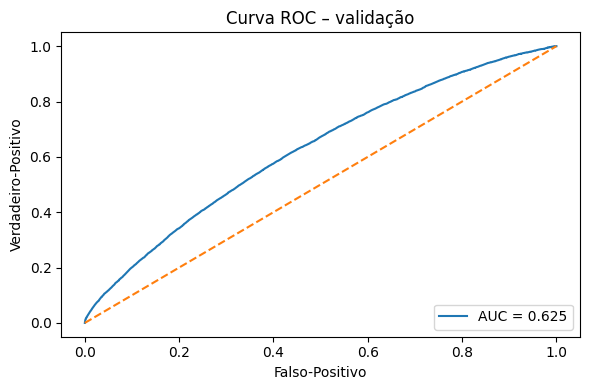

In [16]:
# Probabilidades de inadimplência
y_prob = model.predict(X_valid, num_iteration=model.best_iteration)

# Pontos da curva
fpr, tpr, _ = roc_curve(y_valid, y_prob)
auc = roc_auc_score(y_valid, y_prob)

plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, label=f"AUC = {auc:.3f}")
plt.plot([0,1], [0,1], linestyle="--")          # linha aleatória
plt.xlabel("Falso-Positivo")
plt.ylabel("Verdadeiro-Positivo")
plt.title("Curva ROC – validação")
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()

#### Curva ROC (validação)

- **Eixo Y:** taxa de acerto nos inadimplentes (sensibilidade).  
- **Eixo X:** taxa de falsos alarmes em bons pagadores.  
- Linha tracejada = modelo aleatório.  
- Linha azul = nosso modelo; quanto mais perto do canto ↑ ←, melhor.

- **AUC 0.625** → AUC significa "Área sob a Curva".
    
    Vai de 0.5 (aleatório) a 1.0 (perfeito).

    Aqui, AUC = 0.625 indica um modelo modestamente melhor do que o acaso, mas com espaço claro para melhorias.

A curva mostra que o modelo já está capturando sinal dos inadimplentes, mas ainda de forma limitada. Melhorar a qualidade das features ou aplicar novos modelos pode elevar esse desempenho.

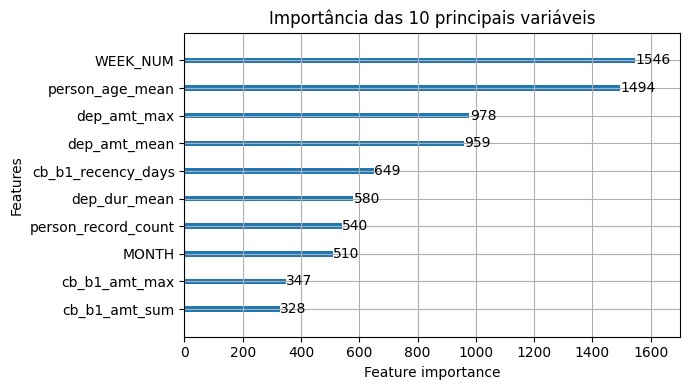

In [17]:
lgb.plot_importance(model, max_num_features=10, figsize=(7,4))
plt.title("Importância das 10 principais variáveis")
plt.tight_layout()
plt.show()

### Insight / Top-10 de variáveis mais importantes

| Rank | Variável | Origem | Por que o modelo gosta | Insight / ação prática |
|------|----------|--------|------------------------|------------------------|
| 1️⃣ | **WEEK_NUM** | base principal | Captura tendência temporal: mudanças econômicas, sazonalidade, ajustes de política. | Monitorar AUC por semana; re-treinar modelo quando desempenho cair. |
| 2️⃣ | **person_age_mean** | `person_1` | Idade média dos envolvidos. Faixas jovens / muito velhas tendem a maior risco. | Ajustar limites ou exigir garantias para extremos de idade. |
| 3️⃣ | **dep_amt_max** | depósitos | Maior depósito já registrado. Reflete capacidade de liquidez pontual. | Limite maior para clientes com pico de depósito alto. |
| 4️⃣ | **dep_amt_mean** | depósitos | Valor médio dos depósitos habituais. | Clientes com média alta apresentam fluxo de caixa estável. |
| 5️⃣ | **cb_b1_recency_days** | bureau B | Dias desde o contrato de crédito mais recente. Quanto menor, mais “fresco” o endividamento. | Endividamento recém-assumido → atenção extra na análise de risco. |
| 6️⃣ | **dep_dur_mean** | depósitos | Duração média dos contratos de depósito. Relacionamento mais longo expressa confiança. | Valorizar histórico de permanência ao definir taxa de juros. |
| 7️⃣ | **person_record_count** | `person_1` | Nº de registros de pessoas ligadas ao caso. | Mais co-mutuários ou fiadores podem diluir ou aumentar exposição, depende da política. |
| 8️⃣ | **MONTH** | base principal | Sazonalidade mensal (13º salário, férias etc.). | Ajustar políticas em meses de risco elevado. |
| 9️⃣ | **cb_b1_amt_max** | bureau B | Maior valor de contrato no bureau. | Endividamento máximo alto → revisar limite de concessão. |
| 🔟 | **cb_b1_amt_sum** | bureau B | Soma de valores de crédito reportados. | Indica alavancagem total; combinar com renda (quando disponível). |

**Observação:**  
`case_id` foi removido, eliminando *data leakage*. `WEEK_NUM` ainda traz sinal temporal legítimo (tendências macro).  
Próximos passos para melhorar o modelo incluem tratar variáveis categóricas (ex.: CatBoost) e incorporar outros grupos de tabelas depth 1/2.

C:\Users\kelve\AppData\Local\Temp\ipykernel_27520\2962073318.py:8: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: 2*roc_auc_score(x["target"], x["score"])-1)


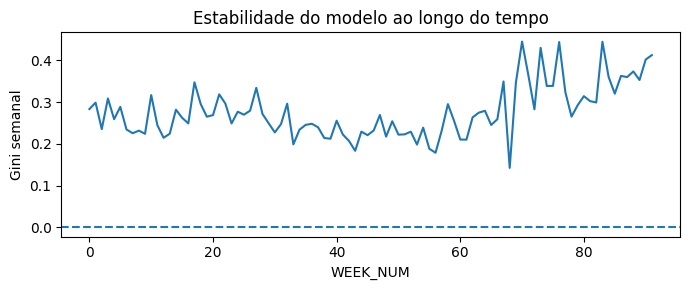

In [18]:
df_pred = df.with_columns(
    pl.Series("score", model.predict(df.select(num_cols).to_pandas()))
)

weekly_gini = (
    df_pred.to_pandas()
           .groupby("WEEK_NUM")
           .apply(lambda x: 2*roc_auc_score(x["target"], x["score"])-1)
)

weekly_gini.plot(figsize=(7,3))
plt.axhline(0, linestyle="--")
plt.ylabel("Gini semanal")
plt.title("Estabilidade do modelo ao longo do tempo")
plt.tight_layout()
plt.show()

#### Gini semanal por WEEK_NUM

Este gráfico avalia a **estabilidade temporal** do modelo.

- O **Gini** mede a capacidade de separação entre pagadores e inadimplentes.
- Observa-se uma performance razoavelmente **consistente** ao longo das semanas.
- Variações são naturais, mas o modelo se mantém **acima de zero**, o que indica valor preditivo estável.
